# A Beginner's Guide to the `MTCOV` Algorithm in the `probinet` Package

In this tutorial, we demonstrate how to use the _Probabilistic Generative Models_ (`probinet`) package to
 run the `MTCOV` algorithm on a sample dataset.

The `MTCOV` (**M**ulti**t**ensor and **Cov**ariates) algorithm is a 
probabilistic generative model designed to perform community detection and broader inference in 
attributed multilayer networks, which are networks enriched with node and edge metadata  {cite}`contisciani2020community`.

## Package Structure
Before explaining how to use the `MTCOV` algorithm, let's explore the structure of the `probinet` package, which is organized into several main modules.

### 1. Input
The `input` module handles data input for subsequent use by the algorithms in the `model` module. It comprises the following submodules:

- `loader`: Functions to load data from input files.
- `preprocessing`: Functions for data preprocessing, such as converting NetworkX graphs to sparse adjacency matrices.
- `stats`: Functions for computing statistics on the data.

### 2. Models
The `models` module contains the implementation of various algorithms, including the following
 submodules:

- `crep`: Implementation of the `CRep` algorithm.
- `jointcrep`: Implementation of the `JointCRep` algorithm.
- `dyncrep`: Implementation of the `DynCRep` algorithm.
- `mtcov`: Implementation of the `MTCOV` algorithm.
- `acd`: Implementation of the `AnomalyCommunityDetection` algorithm.
- `base`: Base classes and utilities for the models.
- `constants`: Constants used across the models.
- `classes`: Classes used across the models.

### 3. Evaluation
The `evaluation` module contains functions responsible for handling the outputs of the models. It
consists of the following submodules:

- `community_detection`: Functions to evaluate the performance of community detection algorithms.
- `expectation_computation`: Functions  for computing expectations and related metrics.
- `likelihood`: Functions for computing the likelihood of the model given the data.
- `link_prediction`: Functions for evaluating link prediction algorithms.

### 4. Synthetic
The `synthetic` module contains functions to generate synthetic data. It consists of the following submodules:

- `base`: Create a synthetic, directed, and weighted network (possibly multilayer) by a standard
mixed-membership stochastic block-model.
- `reciprocity`: Generate a directed, possibly weighted, network with reciprocity.
- `dynamic`: Create synthetic networks that change over time.
- `anomaly`: Generation of synthetic networks with anomalies.
- `multilayer`: Generate synthetic multilayer networks.

An example of how to use the `reciprocity` submodule is shown in the tutorial on the `CRep` algorithm.

### 5. Model Selection
The `model_selection` module contains functions for model selection and cross-validation. It consists of the following submodules:

- `parameter_search`: Functions for searching model parameters.
- `cross_validation`: Functions for performing cross-validation.
- `mtcov_cross_validation`: Cross-validation specific to the `MTCOV` algorithm.
- `dyncrep_cross_validation`: Cross-validation specific to the `DynCRep` algorithm.
- `acd_cross_validation`: Cross-validation specific to the `ACD` algorithm.
- `crep_cross_validation`: Cross-validation specific to the `CRep` algorithm.
- `jointcrep_cross_validation`: Cross-validation specific to the `JointCRep` algorithm.
- `masking`: Functions for masking data during cross-validation.
- `labeling`: Functions for labeling data.
- `main`: Main entry points for running model selection.

### 6. Utils
The `utils` module contains utility functions used across the package. It consists of the following submodules:
- `matrix_operations`: Functions for matrix operations.
- `tools`: General utility functions.

### 7. Main
The `main` module contains the main entry points for running the algorithms.

### 8. Data
The `data` module contains the data files used by the package. It consists of the following submodules:

- `input`: Input data files.
- `model`: Configuration files for the models.

### 9. Visualization
The `visualization` module contains functions for visualizing the results of the models. It
consists of the following submodule:
- `plot`: the main module used for plotting.



Having explored the package structure, let's see how to use it to run the `MTCOV` algorithm.

## Configuration
Let's start by configuring the algorithm and the parameters needed. The pipeline works based on two types of parameters:

**Numerical Parameters:** These are operational parameters that control the execution of the algorithm. They are not directly related to the model's theoretical framework but are crucial for its practical implementation. Examples include:

- **Convergence tolerance (`convergence_tol`):** This is a threshold used to determine when the
algorithm has converged, i.e., when the changes in the model's likelihood or parameters between iterations are small enough to consider the model as having reached its final state.

- **Maximum number of iterations (`max_iter`):** This is the maximum number of times the algorithm will update the model's parameters. If the model hasn't converged by this point, the algorithm will stop anyway.

- **Number of realizations (`num_realizations`):** This refers to the number of times the entire
process (initialization and iterative updates) is repeated. The algorithm will then return the best realization, that is, for instance, the one with the highest likelihood upon convergence. This is done to account for the randomness in the initialization step and to ensure a more robust final model.

These are set by default in the model's class definition, but they can be changed by the user.

**Model parameters:**  These are parameters that are part of the model's theoretical framework. They have a direct impact on the model's behavior and the results it produces. Examples include:

- **Number of communities (`K`)**: This is a fundamental parameter of the algorithms presented in
this package. It determines the number of communities the algorithm will try to find in the network.

- **Scaling parameter (`gamma`)**: This is a fundamental parameter of the `MTCOV` algorithm.
It controls the relative contribution of the two terms in the likelihood, which accounts for network topology and node covariates, respectively. When `gamma=0`, the inference is performed by analyzing the data purely in terms of the network topology. Vice versa, when `gamma=1`, the algorithm only uses the attribute information.


Notice that the data is not a parameter, but an input to the algorithm, hence, it is not included in the default configuration of the class nor in the configuration file. This will be shown later in the tutorial.

As a first step, let's configure the logger to show the information about the execution of the algorithm.

In [1]:
# Import the logging module
import logging

# Get the root logger and set its level to INFO
logging.getLogger().setLevel(logging.INFO)

## Importing the data
We can now import the data using the `probinet` package.

In [4]:
from pathlib import Path
from probinet.input.loader import build_adjacency_and_design_from_file
from probinet.models.classes import GraphData

# Define the names of the columns in the input file that
# represent the source and target nodes of each edge.
ego = "source"
alter = "target"
egoX = "Name"

# Set the `force_dense` flag to False
# This flag determines whether the adjacency matrices
# should be stored as dense matrices.
# If set to False, the adjacency matrices will be stored
# as sparse matrices, which is more memory-efficient
# for large networks with few edges.
force_dense = False

# Get the absolute path of the root directory of the project
root_dir = Path.cwd().parent.parent.parent.resolve()

# Define the path to the input folder
in_folder = str(root_dir / "probinet/data/input/")

# Define the name of the network file
adj_name = "multilayer_network.csv"

# Define the name of the covariates file
cov_name = "X.csv"

# Define the attribute name
attr_name = "Metadata"

# Flag to treat the network as undirected
undirected = False

# Call the `build_adjacency_and_design_from_file` function to load the data from the input file
# The function takes several arguments:
# - in_folder: the path to the data
# - adj_name: the name of the file with the adjacency matrix
# - cov_name: the name of the file with the design matrix
# - ego: the name of the column that references the node in one extreme of the directed edge
# - alter: the name of the column that references the other node
# - attr_name: name of the attribute to consider in the analysis
# - undirected: the flag that signals if the network is undirected
# - force_dense: if set to True, the algorithm is forced to consider a dense adjacency tensor
# - noselfloop : if set to True, the algorithm removes the self-loops
gdata: GraphData = build_adjacency_and_design_from_file(
    in_folder,
    adj_name=adj_name,
    cov_name=cov_name,
    ego=ego,
    alter=alter,
    egoX=egoX,
    attr_name=attr_name,
    undirected=undirected,
    force_dense=force_dense,
    noselfloop=True,
)

To get some information about the data, we can call the `print_graph_stats` function from the 
`input.stats` module.

In [5]:
from probinet.input.stats import print_graph_stats

# Extract the graph list from the `GraphData` object
A = gdata.graph_list

# Call the `print_graph_stats` function to print the basic
# statistics of the graphs in the list `A`.
print_graph_stats(A)

INFO:root:Number of nodes = 300
INFO:root:Number of layers = 4
INFO:root:Number of edges and average degree in each layer:
INFO:root:E[0] = 1294 - <k> = 8.63
INFO:root:Sparsity [0] = 0.014
INFO:root:Reciprocity (networkX) = 0.028
INFO:root:E[1] = 1340 - <k> = 8.93
INFO:root:Sparsity [1] = 0.015
INFO:root:Reciprocity (networkX) = 0.021
INFO:root:E[2] = 724 - <k> = 4.83
INFO:root:Sparsity [2] = 0.008
INFO:root:Reciprocity (networkX) = 0.030
INFO:root:E[3] = 742 - <k> = 4.95
INFO:root:Sparsity [3] = 0.008
INFO:root:Reciprocity (networkX) = 0.003


Let's now show the adjacency matrix of one of the four layers.

In [6]:
import networkx as nx

# Create a graph from the first adjacency matrix in the list A
graph = A[0]

# Get the adjacency matrix
adjacency_matrix = nx.adjacency_matrix(graph)

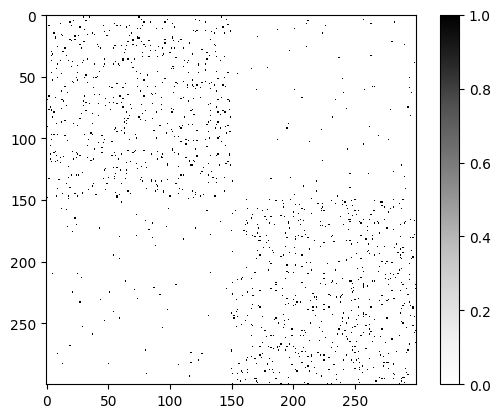

In [7]:
# Import the `pyplot` module from `matplotlib` for creating
# static, animated, and interactive visualizations in Python.
import matplotlib.pyplot as plt

# Display the reshaped adjacency matrix as an image
# The `imshow` function from the `pyplot` module is used to
# display data as an image.
# The `cmap` argument specifies the colormap to use for the image
# The `interpolation` argument specifies the interpolation method
# to use when resizing the image.
plt.imshow(adjacency_matrix.toarray(), cmap="Greys", interpolation="none")

# Add a color bar to the plot for reference
# The colors in the color bar correspond to the values in the image:
# black for 1, meaning a connection, and white for 0, meaning no connection.
plt.colorbar()
plt.show()

As we can see in the matrix, the network is not fully connected, i.e., there are nodes that are not 
connected to any other node. This is a common characteristic of real-world networks. More 
importantly, we can see that the network has two main clusters of nodes, which are represented by the two regions more densely connected. These are the communities that the `MTCOV` algorithm will try to detect.

## Running the Model
Finally, we are ready to run the `MTCOV` model! The way this works is in a two-step process: <br>
1. Initialize the `MTCOV` model by creating an instance of the `MTCOV` class.
2. Execute the `fit` method on the created instance to run the algorithm.

In [8]:
# Import the `MTCOV` class from the `probinet.models.mtcov` module
# This class is used to create an instance of the `MTCOV` algorithm
from probinet.models.mtcov import MTCOV

# Create an instance of the `MTCOV` class
# The `MTCOV` class takes no arguments, unless the user wants
# to change the default of the numerical parameters.
model = MTCOV()

# Print all the attributes of the `MTCOV` instance
# The `__dict__` attribute of an object is a dictionary containing
# the object's attributes.
# These correspond to the numerical parameters
print(model.__dict__)

{'inf': 10000000000.0, 'err_max': 1e-07, 'err': 0.1, 'num_realizations': 1, 'convergence_tol': 0.0001, 'decision': 10, 'max_iter': 500, 'plot_loglik': False, 'flag_conv': 'log', 'attributes_to_save_names': ['u_f', 'v_f', 'w_f', 'eta_f', 'final_it', 'maxL', 'maxPSL', 'beta_f', 'nodes', 'pibr', 'mupr'], 'u_f': array([], dtype=float64), 'v_f': array([], dtype=float64), 'w_f': array([], dtype=float64), 'use_unit_uniform': False, 'theta': {}, 'normalize_rows': False, 'nodes': [], 'rng': RandomState(MT19937) at 0x781E78162A40, 'beta_hat': array([], dtype=float64), 'best_r': 0, 'final_it': 0}


Model created! Now, we can run the model using the `fit` method. As mentioned before, this method
 takes as input the data, and model parameters.

In [9]:
# Import the `time` module
import time

# Import the `numpy` module
import numpy as np

# Define the output folder
out_folder = "tutorial_outputs/MTCOV/"

# Get the current time
time_start = time.time()

# Run the `MTCOV` model
# The `fit` method of the `MTCOV` class takes several arguments:
# - gdata: the data to be analyzed
# - out_inference: if set to True, the algorithm saves the final state of the models
# - out_folder: the folder where the output files will be saved
# - end_file: the ending of the file name

_ = model.fit(
    gdata,
    out_inference=True,
    out_folder=out_folder,
    end_file="_MTCOV",
)

# Print the time elapsed since the start of the `MTCOV` algorithm
print(f"\nTime elapsed: {np.round(time.time() - time_start, 2)} seconds.")

INFO:root:gamma = 0.5
INFO:root:Inferred parameters saved in: /home/dtheuerkauf/software-workshop/prob-gen-model-for-nets/doc/source/tutorials/tutorial_outputs/MTCOV/theta_MTCOV.npz
INFO:root:To load: theta=np.load(filename), then e.g. theta["u"]



Time elapsed: 1.58 seconds.


Done! The final state of the model is not returned, but it is saved to the output folder.

## Analyzing the results
Next, we will examine the outcomes produced by the model. To do this, it is necessary to load the
 contents from the file `theta_MTCOV.npz`, generated by the `fit` method.

In [10]:
# Define the path to the file containing the results of the `MTCOV` models
filename = out_folder + "/theta_MTCOV.npz"

# Load the contents of the file into a dictionary
theta = np.load(filename)

Once this is done, we can unpack the latent variables.

In [11]:
# Unpack the latent variables from the results of the `MTCOV` models
# The `u` variable represents the out-going memberships of the
# nodes in the graph.
# The `v` variable represents the in-coming memberships of the
# nodes in the graph.
# The `w` variable represents the affinity of the communities
# for each layer.
# The `beta` variable represents the relationships between
# communities and covariates.
u, v, w, beta = theta["u"], theta["v"], theta["w"], theta["beta"]

As outlined in the main reference {cite}`contisciani2020community`, `MTCOV` assumes a mixed-membership community structure, which 
means that 
every node can belong to more than one community with a different strength. The variables `u` and
 `v` are _NxK_ membership matrices that represent the out-going and in-coming node memberships, 
 respectively. In this specific demonstration, it's important to recall that we configured the 
 model parameter `K`, representing the number of communities, to be 2. Consequently, by examining the values of `u` for each node, we expect to obtain vector of length two, where the first entry is the probability of node _i_ to belong to community 1 and the second one represents the probability to belong to community 2.

In [12]:
# Iterate over the first 10 nodes in the graph
for idx, values in enumerate(u[:10]):
    # Print the probability that the node belongs to the two communities
    print(
        f"The probability that the node {idx} belongs to the two communities is: {values}"
    )

The probability that the node 0 belongs to the two communities is: [1. 0.]
The probability that the node 1 belongs to the two communities is: [1. 0.]
The probability that the node 2 belongs to the two communities is: [1. 0.]
The probability that the node 3 belongs to the two communities is: [1. 0.]
The probability that the node 4 belongs to the two communities is: [1. 0.]
The probability that the node 5 belongs to the two communities is: [1. 0.]
The probability that the node 6 belongs to the two communities is: [1. 0.]
The probability that the node 7 belongs to the two communities is: [1. 0.]
The probability that the node 8 belongs to the two communities is: [1. 0.]
The probability that the node 9 belongs to the two communities is: [1. 0.]


To visualize the hard-memberships for the out-going case, we can assign each node to the 
community with the highest probability in `u`. We can then print the community assignments for the first 10 nodes.

In [13]:
# Calculate the hard-memberships for the out-going case
u_hard = np.argmax(u, axis=1)

# Get the indices of nodes in community 1 and community 2
community1_nodes = np.where(u_hard == 0)[0]  # Community 1 corresponds to index 0
community2_nodes = np.where(u_hard == 1)[0]  # Community 2 corresponds to index 1

# Print some nodes from community 1
print("Some nodes in community 1:")
print(community1_nodes[:10])

# Print some nodes from community 2
print("\nSome nodes in community 2:")
print(community2_nodes[0:10])

Some nodes in community 1:
[0 1 2 3 4 5 6 7 8 9]

Some nodes in community 2:
[150 151 152 153 154 155 156 157 158 159]


We have learned this way to assign each node to a community, using the results given by the 
`MTCOV` algorithm. For a more graphical approach, we invite the reader to take a look at the tutorial on the 
[`JointCRep` algorithm](./JointCRep.ipynb), where we show how to plot the communities in the 
network.

In addition to investigate the node memberships, we can interpret the relationships between the 
inferred communities and the node covariate through the variable `beta`. As outlined in the main
 reference, 
`beta` is a _KxZ_ dimensional matrix, where _Z_ denotes the total number of different categories 
of the node attribute. In this example, the attribute Metadata has 2 categories. Then, every row 
_k_ of the beta matrix denotes how much information of the different categories is used to create
 the _k_-th community. Also, this variable is normalized such that every row sums to 1.

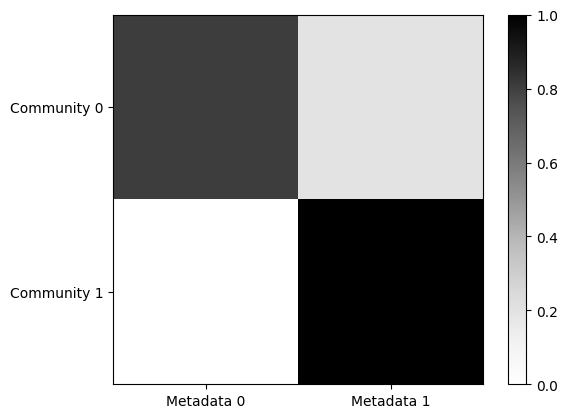

In [14]:
plt.imshow(beta, cmap="Greys", interpolation="none", vmin=0, vmax=1)

plt.xticks([0, 1], ["Metadata 0", "Metadata 1"])
plt.yticks([0, 1], ["Community 0", "Community 1"])

plt.colorbar()
plt.show()

Through this plot, we can infer that community 0 is mainly related to nodes with Metadata 0, while community 1 groups together primarily nodes with attribute Metadata 1.

## Summary

This tutorial provides a comprehensive guide on using the `probinet` package. Specifically, it focuses on the `MTCOV` algorithm, which is a probabilistic generative model used for network analysis, designed to detect communities within a multilayer network where node attributes are considered.

The tutorial explains the structure of the `probinet` package, which is organized into several main modules, such as `input`, `models`, `evaluation`, `synthetic`, `model_selection`, and `utils`. It also demonstrates how to configure and run the `MTCOV` algorithm on the input data imported using the `probinet` package.

Furthermore, it shows how to analyze the results produced by the model. It explains how to load the inferred parameters from a file, unpack the latent variables, and calculate the out-going hard-memberships. It also shows how to interpret the relationships between communities and attribute categories. 

